- Scenario:
Unexpected pollution spikes in certain localities indicate industrial leaks or unreported emissions.

- Objective:
A model for anomaly detection to identify cities or years that show abnormally high pollution patterns compared to neighboring observations.
This helps in discovering hidden hotspots, enabling rapid response and investigation.

In [72]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
import joblib
import matplotlib.pyplot as plt

In [77]:
df = pd.read_csv(r"C:\Desktop\predictiveAnalysis\data\processed\processed_data.csv")

In [78]:
df.head()

,who_region,iso3,country_name,city,year,pm10_concentration,pm25_concentration,no2_concentration,pm10_tempcov,pm25_tempcov,...,type_of_stations,population,latitude,longitude,who_ms,pollution_index,pollution_per_person,pollution_index_yearly_change,pollution_cluster,pollution_severity
0,0.0,0.0,0.0,1.0,2013,-0.170206,-0.354191,0.504059,-0.317035,-2.475293,...,9,0.649804,43.367900,-8.418571,1,-0.095652,-0.041423,0.000000,6,Critical
1,0.0,0.0,0.0,1.0,2014,-0.002639,-0.023508,0.067105,0.260630,-0.169461,...,9,0.663666,43.368033,-8.418233,1,0.008241,-0.042623,2.702171,6,Critical
2,0.0,0.0,0.0,1.0,2015,-0.080175,-0.164766,0.215932,0.389000,-1.102774,...,9,0.663666,43.370375,-8.422900,1,-0.049060,-0.042222,-1.490347,6,Critical
3,0.0,0.0,0.0,1.0,2016,-0.177362,-0.228385,0.096767,0.389000,0.379546,...,9,0.663666,43.370375,-8.422900,1,-0.168826,-0.042543,-3.115034,0,Low
4,0.0,0.0,0.0,1.0,2017,-0.027430,-0.156475,0.159910,0.324815,0.324645,...,9,0.663666,43.370375,-8.422900,1,-0.010575,-0.042373,4.116002,6,Critical


In [79]:
features = [
    "pm10_concentration",
    "pm25_concentration",
    "no2_concentration",
    "pollution_index",
    "latitude",
    "longitude"
]

X = df[features].values


## Isolation Forest


In [91]:
iso = IsolationForest(
    n_estimators=100,
    contamination='auto',  
    random_state=42
)
iso_labels = iso.fit_predict(X)
df['iso_label'] = iso_labels
df['is_anomaly_iso'] = df['iso_label'] == -1

In [92]:
num_anomalies_iso = df['is_anomaly_iso'].sum()
anomaly_percent_iso = (num_anomalies_iso / len(df)) * 100
print(f"[Isolation Forest] Anomalies: {num_anomalies_iso}, Normal: {len(df)-num_anomalies_iso}, Anomaly %: {anomaly_percent_iso:.2f}%")


[Isolation Forest] Anomalies: 4523, Normal: 35575, Anomaly %: 11.28%


## DBSCAN


In [84]:
dbscan = DBSCAN(
    eps=1.5,
    min_samples=5,
    metric='euclidean'
)
dbscan_labels = dbscan.fit_predict(X)
df['dbscan_label'] = dbscan_labels
df['is_anomaly_dbscan'] = df['dbscan_label'] == -1

In [86]:
# Number of anomalies
num_anomalies_db = df['is_anomaly_dbscan'].sum()
anomaly_percent_db = (num_anomalies_db / len(df)) * 100
print(f"[DBSCAN] Anomalies: {num_anomalies_db}, Normal: {len(df)-num_anomalies_db}, Anomaly %: {anomaly_percent_db:.2f}%")


[DBSCAN] Anomalies: 974, Normal: 39124, Anomaly %: 2.43%


- Visualization of hotspots according to anomaly

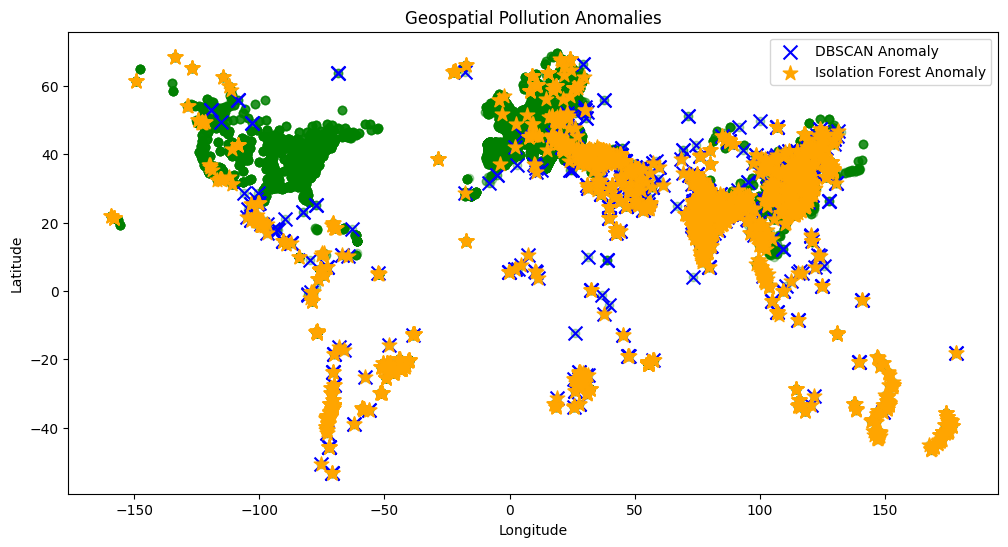

In [102]:
plt.figure(figsize=(12,6))
plt.scatter(df['longitude'], df['latitude'], c='green', alpha=0.3)
plt.scatter(df.loc[df['is_anomaly_dbscan'], 'longitude'],
            df.loc[df['is_anomaly_dbscan'], 'latitude'],
            c='blue', s=100, marker='x', label='DBSCAN Anomaly')
plt.scatter(df.loc[df['is_anomaly_iso'], 'longitude'],
            df.loc[df['is_anomaly_iso'], 'latitude'],
            c='orange', s=120, marker='*', label='Isolation Forest Anomaly')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geospatial Pollution Anomalies")
plt.legend()
plt.show()


In [104]:
joblib.dump(dbscan, "../models/dbscan_pollution_anomaly.pkl")

['../models/dbscan_pollution_anomaly.pkl']

In [105]:
joblib.dump(iso, "../models/isolation_forest_pollution.pkl")

['../models/isolation_forest_pollution.pkl']